In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

import sys
import csv
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.perturbations import *

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [2]:
# Step 1: Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


In [3]:
x_train = trainset.data / 255.0  # Scale pixel values to [0, 1]
y_train = np.array(trainset.targets)
x_test = testset.data / 255.0  # Scale pixel values to [0, 1]
y_test = np.array(testset.targets)

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.eye(num_classes)[y_train].astype(np.float32)
y_test = np.eye(num_classes)[y_test].astype(np.float32)

min_pixel_value = 0.0
max_pixel_value = 1.0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).to(device)
y_train = torch.from_numpy(y_train).to(device)

x_test = torch.from_numpy(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device)

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = SimpleDataset(x_train, y_train)
test_dataset = SimpleDataset(x_test, y_test)

In [6]:
test_history = []

def display_test_history(test_history, eps_values):
    for i in range(len(test_history)):
        test = test_history[i]
        num_p = len(test['perturbations'])
        training_time = test['training_time']

        baseline = test['baseline_test_accuracy']
        adv_str = ""
        for eps in eps_values:
            adv_acc = test[f'adversarial_accuracy_eps={eps}']
            adv_str += f"[eps={eps}:{adv_acc*100:.2f}%],"
        adv_str = adv_str[:-1]
        print(f"Test {i}: # Perturbations ({num_p}), Time ({training_time:.2f}s), Baseline ({baseline*100:.2f}%), Adversarial ({adv_str})")

def save_to_csv(data, filename):
    if not data:
        return

    # Extract the keys from the first dictionary as headers
    headers = list(data[0].keys())

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write the headers
        writer.writeheader()

        # Write each dictionary as a row in the CSV file
        for item in data:
            writer.writerow(item)

    print(f"Data saved to {filename} successfully.")

In [7]:
class Perturbations():
    def __init__(self, perturbations, include_original=False, shuffle=True):
        self.perturbations = perturbations
        self.multiplicity = len(perturbations) + int(include_original)
        self.shuffle = shuffle
        self.include_original = include_original
    
    def __getitem__(self, idx):
        return self.perturbations[idx]
    
    def __len__(self):
        return len(self.perturbations)

    def get_multiplicity(self):
        if len(self.perturbations) == 0 and not self.include_original:
            return 1
        return self.multiplicity
        
    def get_include_original(self):
        return len(self.perturbations) == 0 or self.include_original
    
    def get_shuffle(self):
        return self.shuffle

    def add_perturbation(self, perturbation):
        if type(perturbation) == list:
            self.perturbations.append(perturbation[0])
        else:
            self.perturbations.append(perturbation)
        self.multiplicity = len(self.perturbations) + int(self.include_original)

In [8]:
class REPClassifier(nn.Module):
    def __init__(self, perturbations):
        super(REPClassifier, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.perturbations = perturbations
        self.multiplicity = perturbations.get_multiplicity()
        self.include_original = perturbations.get_include_original()
        self.shuffle = perturbations.get_shuffle()

        self.conv1 = nn.Conv2d(3*self.multiplicity, 96, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(96, 96, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(96, 80, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(80, 64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(64, 96, kernel_size=5, padding=2)
        self.global_pool = nn.AdaptiveMaxPool2d((2, 2))

        self.fc1 = nn.Linear(96*2*2, 256)
        self.nonlinearity1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.to(self.device)

    def forward(self, x):
        x = x.to(self.device) # shape = (Batch, Color Channels, Height, Width)
        if x.dim() == 3:
            x = x.unsqueeze(0)
        B = x.size(0)

        # Apply perturbations
        layers = []
        if self.include_original:
            layers.append(x)
        for perturbation in self.perturbations:
            layers.append(perturbation(x))
        if self.shuffle:
            permutation = torch.randperm(len(layers))
            layers = [layers[i] for i in permutation]
        # stack along color channel dimension -> shape = (Batch, Color Channels x Multiplicity, H, W)
        x = torch.cat(layers, dim=1) 

        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.global_pool(x)
        x = x.view(B, -1)

        x = self.fc1(x)
        x = self.nonlinearity1(x)
        x = self.fc2(x)
        return x

In [9]:
from tqdm.auto import tqdm

def train_REPClassifier(model, dataset, optimizer, criterion, batch_size, epochs, test_dataset=None, verbose=True):
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=0)
    test_accuracy_history = []
    test_loss_history = []
    for _ in tqdm(range(epochs), disable=not verbose, desc="Epochs"):
        for x_batch, y_batch in dataloader:            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform prediction
            model_outputs = model(x_batch)

            y_batch = y_batch.squeeze(1)
            predictions = model_outputs.squeeze(1)
            
            loss = criterion(predictions, y_batch)

            # Do training
            loss.backward()

            optimizer.step()
        if test_dataset:
            with torch.no_grad():
                x_test = test_dataset.x
                y_test = test_dataset.y
                test_outputs = model(x_test)
                test_predictions = test_outputs.squeeze(1)
                y_test = y_test.squeeze(1)

                test_loss = criterion(test_predictions, y_test)
                test_loss_history.append(test_loss.item().cpu().numpy())

                test_accuracy = torch.sum(torch.argmax(test_outputs, axis=1) == torch.argmax(y_test, axis=1)) / len(x_test)
                test_accuracy_history.append(test_accuracy.cpu())
    return test_accuracy_history, test_loss_history

# Test Single Model

In [51]:
perturbation_descriptions = [["Gaussian", 0.05], ["Laplacian", 0.05]]
# perturbation_descriptions = [["Gaussian", 0.05]]
# perturbation_descriptions = []
perturbation_descriptions = [["Identity"], ["Gaussian", 0.05], ["Laplacian", 0.05], ["Lp-norm", 0.5, 1]]
perturbation_functions = create_perturbations(perturbation_descriptions)

perturbations = Perturbations(perturbation_functions)

In [47]:
model = REPClassifier(perturbations)

In [48]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

922426


In [12]:
load_trained_model = True
model_name = "model1.pt"
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 20

if load_trained_model:
    state_dict = torch.load(ROOT + "src/models/" + model_name)
    model.load_state_dict(state_dict)
else:
    accuracy, loss = train_REPClassifier(model, train_dataset, optimizer, criterion, batch_size, epochs)
    torch.save(model.state_dict(), ROOT + "src/models/" + model_name)

In [14]:
with torch.no_grad():
    train_accuracy = torch.sum(torch.argmax(model(x_train[:1200]), axis=1) == torch.argmax(y_train[:1200], axis=1)) / len(x_train[:1200])
    test_accuracy = torch.sum(torch.argmax(model(x_test), axis=1) == torch.argmax(y_test, axis=1)) / len(x_test)
    print(f"Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")

Train Acc: 0.8758333325386047, Test Acc: 0.7216999530792236


In [15]:
classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 32, 32),
        nb_classes=num_classes,
    )

x_test_numpy = x_test.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()
with torch.no_grad():
    # Step 5: Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(x_test_numpy)
    baseline_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(baseline_accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.025)
x_test_adv1 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv1)
    adversarial_accuracy1 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.025): {}%".format(adversarial_accuracy1 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.05)
x_test_adv2 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv2)
    adversarial_accuracy2 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.05): {}%".format(adversarial_accuracy2 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.075)
x_test_adv3 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv3)
    adversarial_accuracy3 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.075): {}%".format(adversarial_accuracy3 * 100))

attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv4 = attack.generate(x=x_test_numpy)
with torch.no_grad():
    predictions = classifier.predict(x_test_adv4)
    adversarial_accuracy4 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test)
    print("Accuracy on adversarial test examples (epsilon = 0.1): {}%".format(adversarial_accuracy4 * 100))

Accuracy on benign test examples: 72.17%
Accuracy on adversarial test examples (epsilon = 0.025): 18.83%
Accuracy on adversarial test examples (epsilon = 0.05): 13.77%
Accuracy on adversarial test examples (epsilon = 0.075): 11.99%
Accuracy on adversarial test examples (epsilon = 0.1): 10.59%


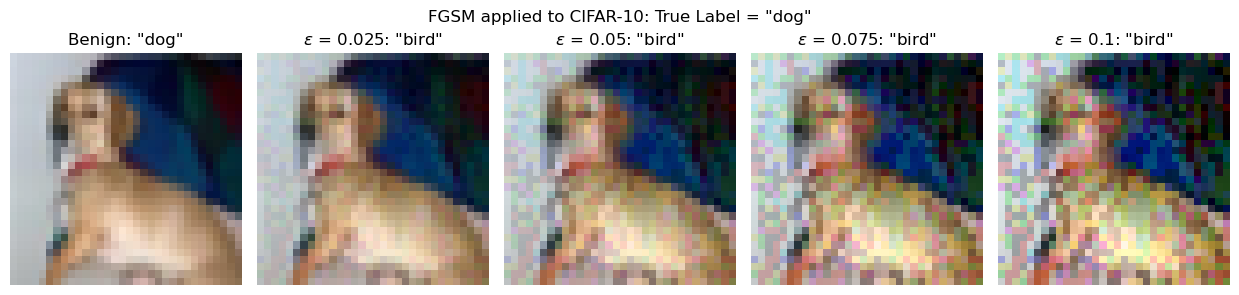

In [39]:
def plot_adversarial_examples(classifier, x_benign, x_adv_list, epsilons, y_true):
    num_examples = len(x_adv_list) + 1
    fig, axes = plt.subplots(1, num_examples, figsize=(num_examples*2.5, 3))
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Predict labels using the classifier
    labels = []
    labels.append(classes[np.argmax(classifier.predict(x_benign), axis=1)[0]])
    for x_adv in x_adv_list:
        labels.append(classes[np.argmax(classifier.predict(x_adv), axis=1)[0]])
    
    # Plot benign example
    axes[0].imshow(x_benign.transpose(1, 2, 0))
    axes[0].set_title(f"Benign: \"{labels[0]}\"")
    axes[0].axis('off')

    # Plot adversarial examples
    for i, x_adv in enumerate(x_adv_list):
        axes[i+1].imshow(x_adv.transpose(1, 2, 0))
        axes[i+1].set_title(f"$\\varepsilon$ = {epsilons[i]}: \"{labels[i+1]}\"")
        axes[i+1].axis('off')

    fig.suptitle(f"FGSM applied to CIFAR-10: True Label = \"{classes[y_true]}\"")
    plt.tight_layout()
    plt.show()

# Example usage
epsilons = [0.025, 0.05, 0.075, 0.1]

# Select a random benign example and its corresponding adversarial examples
idx = np.random.randint(len(x_test_numpy))
x_benign = x_test_numpy[idx]
x_adv_list = [x_test_adv1[idx], x_test_adv2[idx], x_test_adv3[idx], x_test_adv4[idx]]
y_true = np.argmax(y_test_numpy[idx])

plot_adversarial_examples(classifier, x_benign, x_adv_list, epsilons, y_true)

# Test Multiple Models

In [10]:
single_perturbations = [
    ["Identity"],
    ["Gaussian", 0.05],
    [["Gaussian", 0.05],["RotationFlip", 0.3]],
    [["Gaussian", 0.05],["SaltPepper", 0.05]],
    ["Gaussian", 0.1],
    [["Gaussian", 0.1],["RotationFlip", 0.3]],
    [["Gaussian", 0.1],["SaltPepper", 0.05]],
    ["Laplacian", 0.05],
    [["Laplacian", 0.05],["RotationFlip", 0.3]],
    [["Laplacian", 0.05],["SaltPepper", 0.05]],
    ["Laplacian", 0.1],
    [["Laplacian", 0.1],["RotationFlip", 0.3]],
    [["Laplacian", 0.1],["SaltPepper", 0.05]],
    ["Lp-norm", 0.25, 1],
    [["Lp-norm", 0.25, 1],["RotationFlip", 0.3]],
    [["Lp-norm", 0.25, 1],["SaltPepper", 0.05]],
    ["Lp-norm", 0.5, 1],
    [["Lp-norm", 0.5, 1],["RotationFlip", 0.3]],
    [["Lp-norm", 0.5, 1],["SaltPepper", 0.05]],
    ["Lp-norm", 0.25, 2],
    [["Lp-norm", 0.25, 2],["RotationFlip", 0.3]],
    [["Lp-norm", 0.25, 2],["SaltPepper", 0.05]],
    ["Lp-norm", 0.5, 2],
    [["Lp-norm", 0.5, 2],["RotationFlip", 0.3]],
    [["Lp-norm", 0.5, 2],["SaltPepper", 0.05]],
    ["Lp-norm", 0.25, 3],
    [["Lp-norm", 0.25, 3],["RotationFlip", 0.3]],
    [["Lp-norm", 0.25, 3],["SaltPepper", 0.05]],
    ["Lp-norm", 0.5, 3],
    [["Lp-norm", 0.5, 3],["RotationFlip", 0.3]],
    [["Lp-norm", 0.5, 3],["SaltPepper", 0.05]],
    ["Lp-norm", 0.25, 4],
    [["Lp-norm", 0.25, 4],["RotationFlip", 0.3]],
    [["Lp-norm", 0.25, 4],["SaltPepper", 0.05]],
    ["Lp-norm", 0.5, 4],
    [["Lp-norm", 0.5, 4],["RotationFlip", 0.3]],
    [["Lp-norm", 0.5, 4],["SaltPepper", 0.05]],
    ["Lp-norm", 0.25, float('inf')],
    [["Lp-norm", 0.25, float('inf')],["RotationFlip", 0.3]],
    [["Lp-norm", 0.25, float('inf')],["SaltPepper", 0.05]],
    ["Lp-norm", 0.5, float('inf')],
    [["Lp-norm", 0.5, float('inf')],["RotationFlip", 0.3]],
    [["Lp-norm", 0.5, float('inf')],["SaltPepper", 0.05]],
]

def create_joint_perturbation_description(individual_perturbations, indices):
    joint_perturbation = []
    for idx in indices:
        joint_perturbation.append(individual_perturbations[idx])
    return joint_perturbation

joint_perturbations = [
    create_joint_perturbation_description(single_perturbations, [11, 12]),                  # top-2 individuals at adversarial performance
    create_joint_perturbation_description(single_perturbations, [11, 12, 41]),              # top-3 ...
    create_joint_perturbation_description(single_perturbations, [11, 12, 41, 5]),           # top-4 ...
    create_joint_perturbation_description(single_perturbations, [11, 12, 41, 5, 42]),       # top-5 ...      
    create_joint_perturbation_description(single_perturbations, [22, 19]),                  # top-2 individuals at benign test performance
    create_joint_perturbation_description(single_perturbations, [22, 19, 31]),              # top-3 ...
    create_joint_perturbation_description(single_perturbations, [22, 19, 31, 13]),          # top-4 ...
    create_joint_perturbation_description(single_perturbations, [22, 19, 31, 13, 25]),      # top-5 ...
    create_joint_perturbation_description(single_perturbations, [11, 22]),                  # top-1 adversarial and top-1 benign test
    create_joint_perturbation_description(single_perturbations, [11, 12, 22, 19]),          # top-2 of each
    create_joint_perturbation_description(single_perturbations, [11, 12, 41, 22, 19, 31]),  # top-3 of each         
    create_joint_perturbation_description(single_perturbations, [12, 42]),                  # top-2 individuals at maximum adversarial accuracy gain minus benign test accuracy loss
    create_joint_perturbation_description(single_perturbations, [12, 42, 6]),               # top-3 ...
    create_joint_perturbation_description(single_perturbations, [12, 42, 6, 9]),            # top-4 ...
    create_joint_perturbation_description(single_perturbations, [12, 42, 6, 9, 11]),        # top-5 ...
]

all_perturbations = [Perturbations(create_perturbations(perturbation_description), shuffle=True, include_original=True) for perturbation_description in joint_perturbations]

In [12]:
test_name = "FRESH_CNN_CIFAR_10_4_IncludeOriginal"
test_history = []
epochs = 20
batch_size = 64
criterion = nn.CrossEntropyLoss()

eps_values = [0.025, 0.05, 0.075, 0.1]
x_train_numpy = x_train.cpu().numpy()
y_train_numpy = y_train.cpu().numpy()
x_test_numpy = x_test.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()

initial_index = len(test_history)

for i in range(initial_index, len(all_perturbations)):
    perturbations = all_perturbations[i]
    model_name = f"model{initial_index + i}.pt"
    
    model = REPClassifier(perturbations)
    lr = 0.0001
    weight_decay = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    print(f"Training {model_name} with perturbations:")
    print(joint_perturbations[i])

    # Train model
    training_start = time.time()
    train_REPClassifier(model, train_dataset, optimizer, criterion, batch_size, epochs)
    training_time = time.time() - training_start
    torch.save(model.state_dict(), ROOT + "src/models/" + test_name + "/" + model_name)
    print(f"Training Complete After: {training_time}s")


    # Insert the model into the pytorch classifier from ART to allow for adversarial attack generation
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_pixel_value, max_pixel_value),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 32, 32),
        nb_classes=num_classes,
    )

    # Evaluate on benign examples
    with torch.no_grad():
        train_predictions = classifier.predict(x_train_numpy)
        baseline_train_accuracy = np.sum(np.argmax(train_predictions, axis=1) == np.argmax(y_train_numpy, axis=1)) / len(y_train_numpy)
        print("Accuracy on benign train examples: {}%".format(baseline_train_accuracy * 100))
        
        test_predictions = classifier.predict(x_test_numpy)
        baseline_test_accuracy = np.sum(np.argmax(test_predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
        print("Accuracy on benign test examples: {}%".format(baseline_test_accuracy * 100))
    
    test_history.append({
        'perturbations': joint_perturbations[i],
        'include_original': perturbations.get_include_original(),
        'shuffle': perturbations.get_shuffle(),
        'loss': criterion,
        'lr': lr,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs': epochs,
        'training_time': training_time,
        'baseline_train_accuracy': baseline_train_accuracy,
        'baseline_test_accuracy': baseline_test_accuracy,
        })

    # Evaluate against FGSM
    for eps in eps_values:
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        x_test_adv = attack.generate(x=x_test_numpy)
        with torch.no_grad():
            predictions = classifier.predict(x_test_adv)
            adversarial_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_numpy, axis=1)) / len(y_test_numpy)
            print(f"Accuracy on adversarial test examples (epsilon = {eps}): {adversarial_accuracy * 100:.2f}%")
        test_history[initial_index + i][f"adversarial_accuracy_eps={eps}"] = adversarial_accuracy
display_test_history(test_history, eps_values)

Training model0.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 184.2925283908844s
Accuracy on benign train examples: 75.484%
Accuracy on benign test examples: 67.2%
Accuracy on adversarial test examples (epsilon = 0.025): 38.73%
Accuracy on adversarial test examples (epsilon = 0.05): 21.32%
Accuracy on adversarial test examples (epsilon = 0.075): 16.14%
Accuracy on adversarial test examples (epsilon = 0.1): 14.77%
Training model1.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 199.34770965576172s
Accuracy on benign train examples: 74.144%
Accuracy on benign test examples: 66.41%
Accuracy on adversarial test examples (epsilon = 0.025): 39.23%
Accuracy on adversarial test examples (epsilon = 0.05): 22.20%
Accuracy on adversarial test examples (epsilon = 0.075): 16.93%
Accuracy on adversarial test examples (epsilon = 0.1): 14.86%
Training model2.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Gaussian', 0.1], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 206.39597034454346s
Accuracy on benign train examples: 73.762%
Accuracy on benign test examples: 65.53%
Accuracy on adversarial test examples (epsilon = 0.025): 36.96%
Accuracy on adversarial test examples (epsilon = 0.05): 22.33%
Accuracy on adversarial test examples (epsilon = 0.075): 16.97%
Accuracy on adversarial test examples (epsilon = 0.1): 16.09%
Training model3.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], [['Gaussian', 0.1], ['RotationFlip', 0.3]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 210.0063033103943s
Accuracy on benign train examples: 76.926%
Accuracy on benign test examples: 67.52%
Accuracy on adversarial test examples (epsilon = 0.025): 32.76%
Accuracy on adversarial test examples (epsilon = 0.05): 19.70%
Accuracy on adversarial test examples (epsilon = 0.075): 16.28%
Accuracy on adversarial test examples (epsilon = 0.1): 14.05%
Training model4.pt with perturbations:
[['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 82.13929343223572s
Accuracy on benign train examples: 86.176%
Accuracy on benign test examples: 72.59%
Accuracy on adversarial test examples (epsilon = 0.025): 16.54%
Accuracy on adversarial test examples (epsilon = 0.05): 12.80%
Accuracy on adversarial test examples (epsilon = 0.075): 11.38%
Accuracy on adversarial test examples (epsilon = 0.1): 10.18%
Training model5.pt with perturbations:
[['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 4]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 81.16798114776611s
Accuracy on benign train examples: 87.374%
Accuracy on benign test examples: 72.3%
Accuracy on adversarial test examples (epsilon = 0.025): 18.95%
Accuracy on adversarial test examples (epsilon = 0.05): 14.47%
Accuracy on adversarial test examples (epsilon = 0.075): 13.22%
Accuracy on adversarial test examples (epsilon = 0.1): 12.28%
Training model6.pt with perturbations:
[['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 4], ['Lp-norm', 0.25, 1]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 89.69455766677856s
Accuracy on benign train examples: 88.718%
Accuracy on benign test examples: 72.81%
Accuracy on adversarial test examples (epsilon = 0.025): 18.18%
Accuracy on adversarial test examples (epsilon = 0.05): 13.82%
Accuracy on adversarial test examples (epsilon = 0.075): 12.64%
Accuracy on adversarial test examples (epsilon = 0.1): 11.36%
Training model7.pt with perturbations:
[['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 4], ['Lp-norm', 0.25, 1], ['Lp-norm', 0.25, 3]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 95.60471415519714s
Accuracy on benign train examples: 87.482%
Accuracy on benign test examples: 72.35000000000001%
Accuracy on adversarial test examples (epsilon = 0.025): 18.44%
Accuracy on adversarial test examples (epsilon = 0.05): 14.21%
Accuracy on adversarial test examples (epsilon = 0.075): 12.95%
Accuracy on adversarial test examples (epsilon = 0.1): 11.47%
Training model8.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 2]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 133.1327018737793s
Accuracy on benign train examples: 77.704%
Accuracy on benign test examples: 69.81%
Accuracy on adversarial test examples (epsilon = 0.025): 33.38%
Accuracy on adversarial test examples (epsilon = 0.05): 18.57%
Accuracy on adversarial test examples (epsilon = 0.075): 14.03%
Accuracy on adversarial test examples (epsilon = 0.1): 13.21%
Training model9.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]], ['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 194.6463725566864s
Accuracy on benign train examples: 83.02000000000001%
Accuracy on benign test examples: 70.57%
Accuracy on adversarial test examples (epsilon = 0.025): 27.41%
Accuracy on adversarial test examples (epsilon = 0.05): 16.24%
Accuracy on adversarial test examples (epsilon = 0.075): 14.02%
Accuracy on adversarial test examples (epsilon = 0.1): 13.58%
Training model10.pt with perturbations:
[[['Laplacian', 0.1], ['RotationFlip', 0.3]], [['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['RotationFlip', 0.3]], ['Lp-norm', 0.5, 2], ['Lp-norm', 0.25, 2], ['Lp-norm', 0.25, 4]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 210.1992335319519s
Accuracy on benign train examples: 83.634%
Accuracy on benign test examples: 69.6%
Accuracy on adversarial test examples (epsilon = 0.025): 26.25%
Accuracy on adversarial test examples (epsilon = 0.05): 16.06%
Accuracy on adversarial test examples (epsilon = 0.075): 14.30%
Accuracy on adversarial test examples (epsilon = 0.1): 13.65%
Training model11.pt with perturbations:
[[['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 149.7066032886505s
Accuracy on benign train examples: 83.536%
Accuracy on benign test examples: 70.21%
Accuracy on adversarial test examples (epsilon = 0.025): 30.82%
Accuracy on adversarial test examples (epsilon = 0.05): 16.66%
Accuracy on adversarial test examples (epsilon = 0.075): 13.80%
Accuracy on adversarial test examples (epsilon = 0.1): 13.03%
Training model12.pt with perturbations:
[[['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Gaussian', 0.1], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 159.5630795955658s
Accuracy on benign train examples: 82.93199999999999%
Accuracy on benign test examples: 68.74%
Accuracy on adversarial test examples (epsilon = 0.025): 28.37%
Accuracy on adversarial test examples (epsilon = 0.05): 16.64%
Accuracy on adversarial test examples (epsilon = 0.075): 14.68%
Accuracy on adversarial test examples (epsilon = 0.1): 14.31%
Training model13.pt with perturbations:
[[['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Gaussian', 0.1], ['SaltPepper', 0.05]], [['Laplacian', 0.05], ['SaltPepper', 0.05]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 211.33956360816956s
Accuracy on benign train examples: 85.98599999999999%
Accuracy on benign test examples: 70.75%
Accuracy on adversarial test examples (epsilon = 0.025): 26.92%
Accuracy on adversarial test examples (epsilon = 0.05): 15.37%
Accuracy on adversarial test examples (epsilon = 0.075): 13.75%
Accuracy on adversarial test examples (epsilon = 0.1): 12.54%
Training model14.pt with perturbations:
[[['Laplacian', 0.1], ['SaltPepper', 0.05]], [['Lp-norm', 0.5, inf], ['SaltPepper', 0.05]], [['Gaussian', 0.1], ['SaltPepper', 0.05]], [['Laplacian', 0.05], ['SaltPepper', 0.05]], [['Laplacian', 0.1], ['RotationFlip', 0.3]]]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete After: 262.84348034858704s
Accuracy on benign train examples: 83.506%
Accuracy on benign test examples: 70.15%
Accuracy on adversarial test examples (epsilon = 0.025): 30.01%
Accuracy on adversarial test examples (epsilon = 0.05): 16.44%
Accuracy on adversarial test examples (epsilon = 0.075): 14.63%
Accuracy on adversarial test examples (epsilon = 0.1): 13.27%
Test 0: # Perturbations (2), Time (184.29s), Baseline (67.20%), Adversarial ([eps=0.025:38.73%],[eps=0.05:21.32%],[eps=0.075:16.14%],[eps=0.1:14.77%])
Test 1: # Perturbations (3), Time (199.35s), Baseline (66.41%), Adversarial ([eps=0.025:39.23%],[eps=0.05:22.20%],[eps=0.075:16.93%],[eps=0.1:14.86%])
Test 2: # Perturbations (4), Time (206.40s), Baseline (65.53%), Adversarial ([eps=0.025:36.96%],[eps=0.05:22.33%],[eps=0.075:16.97%],[eps=0.1:16.09%])
Test 3: # Perturbations (5), Time (210.01s), Baseline (67.52%), Adversarial ([eps=0.025:32.76%],[eps=0.05:19.70%],[eps=0.075:16.28%],[eps=0.1:14.05%])
Test 4: # Pert

In [13]:
save_to_csv(test_history, ROOT + "notebooks/experiment_log/" + test_name + ".csv")

Data saved to ../../notebooks/experiment_log/FRESH_CNN_CIFAR_10_4_IncludeOriginal.csv successfully.
